In [3]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [4]:
dataset = datasets.MNIST('.', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1275480A0>, 5)

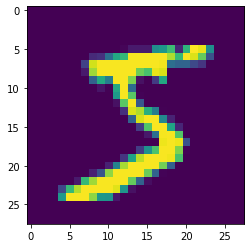

In [6]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[0].detach().numpy())
plt.show()

In [7]:
def collate_fn(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1),
      'target': target,
      }


In [21]:
# hyperparams
inp_dim = 28 * 28
#try to use other model params. check overfitting with large models
hidden_dim1 = 350
hidden_dim2 = 250
hidden_dim3 = 350
out_dim = 80
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

# Обучение AE собственной архитектуры на MNIST

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.do1 = nn.Dropout(0.1)
        self.activ1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.do2 = nn.Dropout(0.1)
        self.activ2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.do3 = nn.Dropout(0.1)
        self.activ3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, out_dim)

    def forward(self, x):
        x = self.do1(self.activ1(self.linear1(x)))
        x = self.do2(self.activ2(self.linear2(x)))
        x = self.do3(self.activ3(self.linear3(x)))
        x = self.linear4(x)

        return x

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(out_dim, hidden_dim3)
        self.do1 = nn.Dropout(0.1)
        self.activ1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim3, hidden_dim2)
        self.do2 = nn.Dropout(0.1)
        self.activ2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim1)
        self.do3 = nn.Dropout(0.1)
        self.activ3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, input_dim)

    def forward(self, x):
        x = self.do1(self.activ1(self.linear1(x)))
        x = self.do2(self.activ2(self.linear2(x)))
        x = self.do3(self.activ3(self.linear3(x)))
        x = self.linear4(x)

        return x

class LinearAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, out_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, out_dim)
        self.decoder = Decoder(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, out_dim)
                           
    def forward(self, x):
        hidden = self.encoder(x)
        x_ = self.decoder(hidden)
        return x_


In [27]:
model = LinearAutoEncoder(inp_dim, hidden_dim1 ,hidden_dim2, hidden_dim3, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()


epoch: 0, step: 0, loss: 0.10861822217702866
epoch: 0, step: 200, loss: 0.044784367084503174
epoch: 0, step: 400, loss: 0.03684433549642563


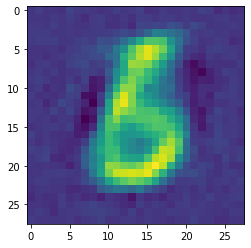

epoch: 1, step: 0, loss: 0.03741380572319031
epoch: 1, step: 200, loss: 0.03236382454633713
epoch: 1, step: 400, loss: 0.030645126476883888


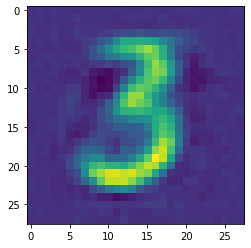

epoch: 2, step: 0, loss: 0.029633786529302597
epoch: 2, step: 200, loss: 0.02874920517206192
epoch: 2, step: 400, loss: 0.02625574916601181


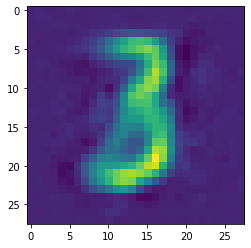

epoch: 3, step: 0, loss: 0.02400992065668106
epoch: 3, step: 200, loss: 0.02470145933330059
epoch: 3, step: 400, loss: 0.024930983781814575


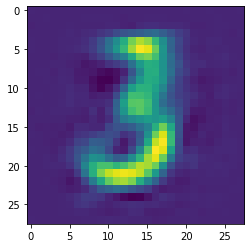

epoch: 4, step: 0, loss: 0.024197228252887726
epoch: 4, step: 200, loss: 0.02451234869658947
epoch: 4, step: 400, loss: 0.023575756698846817


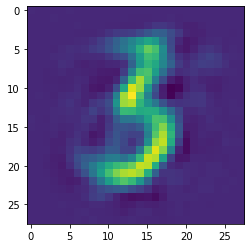

epoch: 5, step: 0, loss: 0.023496562615036964
epoch: 5, step: 200, loss: 0.022848520427942276
epoch: 5, step: 400, loss: 0.022048411890864372


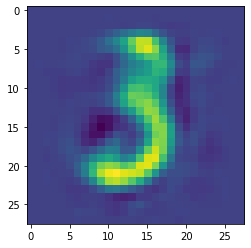

epoch: 6, step: 0, loss: 0.023275455459952354
epoch: 6, step: 200, loss: 0.02433386631309986
epoch: 6, step: 400, loss: 0.023380303755402565


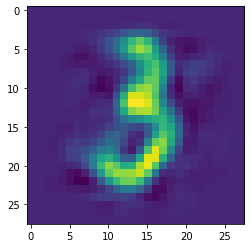

epoch: 7, step: 0, loss: 0.022446170449256897
epoch: 7, step: 200, loss: 0.02302120253443718
epoch: 7, step: 400, loss: 0.021714292466640472


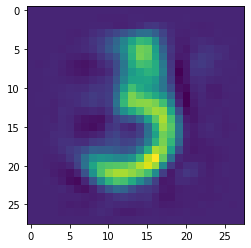

epoch: 8, step: 0, loss: 0.020375024527311325
epoch: 8, step: 200, loss: 0.023164382204413414
epoch: 8, step: 400, loss: 0.023198682814836502


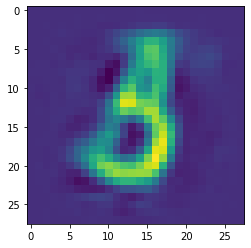

epoch: 9, step: 0, loss: 0.020798087120056152
epoch: 9, step: 200, loss: 0.022145668044686317
epoch: 9, step: 400, loss: 0.021955544129014015


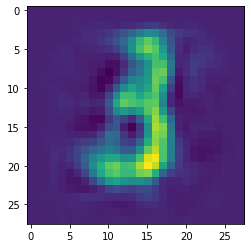

In [28]:
# hidden_out = 40
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model(batch['data'].to(device))
    loss = loss_func(batch['data'].to(device), predict)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).view(1, -1).float()/255
  plt.imshow(model(item).view((28, 28)).detach().numpy())
  plt.show()
  torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')


epoch: 0, step: 0, loss: 0.021051036193966866
epoch: 0, step: 200, loss: 0.019154999405145645
epoch: 0, step: 400, loss: 0.020841171965003014


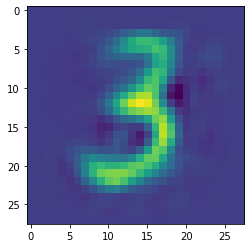

epoch: 1, step: 0, loss: 0.02013230323791504
epoch: 1, step: 200, loss: 0.019614314660429955
epoch: 1, step: 400, loss: 0.02016283944249153


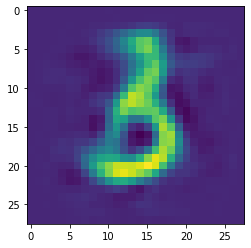

epoch: 2, step: 0, loss: 0.02086472511291504
epoch: 2, step: 200, loss: 0.019001062959432602
epoch: 2, step: 400, loss: 0.020396417006850243


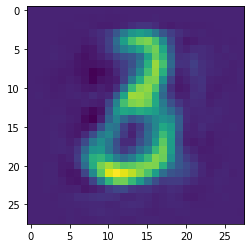

epoch: 3, step: 0, loss: 0.019800033420324326
epoch: 3, step: 200, loss: 0.01960526779294014
epoch: 3, step: 400, loss: 0.02049851603806019


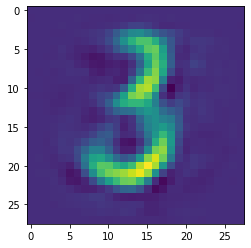

epoch: 4, step: 0, loss: 0.020432384684681892
epoch: 4, step: 200, loss: 0.01943918690085411
epoch: 4, step: 400, loss: 0.020893899723887444


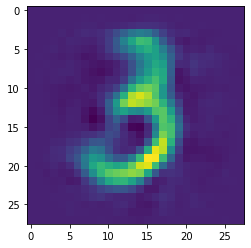

epoch: 5, step: 0, loss: 0.021154087036848068
epoch: 5, step: 200, loss: 0.020105915144085884
epoch: 5, step: 400, loss: 0.01924409158527851


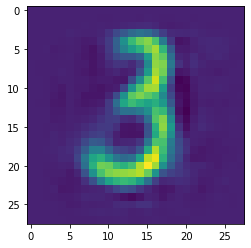

epoch: 6, step: 0, loss: 0.019785447046160698
epoch: 6, step: 200, loss: 0.018663063645362854
epoch: 6, step: 400, loss: 0.01987408474087715


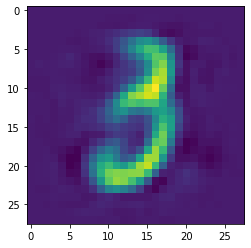

epoch: 7, step: 0, loss: 0.019873738288879395
epoch: 7, step: 200, loss: 0.020690320059657097
epoch: 7, step: 400, loss: 0.0194072425365448


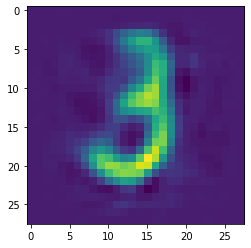

epoch: 8, step: 0, loss: 0.018623685464262962
epoch: 8, step: 200, loss: 0.017373373731970787
epoch: 8, step: 400, loss: 0.01781494729220867


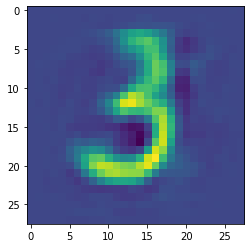

epoch: 9, step: 0, loss: 0.019100118428468704
epoch: 9, step: 200, loss: 0.01968427747488022
epoch: 9, step: 400, loss: 0.020139779895544052


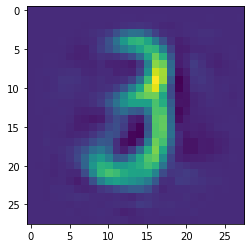

In [29]:
# hidden_out = 80
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model(batch['data'].to(device))
    loss = loss_func(batch['data'].to(device), predict)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).view(1, -1).float()/255
  plt.imshow(model(item).view((28, 28)).detach().numpy())
  plt.show()
  torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')


# Обучение VAE собственной архитектуры на MNIST